In [0]:
DRIVE = True

load_data = True
load_resnet = "./ImageResNet.h5"  # Leave blank to train and save ...

data_path = {
    "train": "./data/img_features/img_train.npy", 
    "test": "./data/img_features/img_test.npy", 
    "val": "./data/img_features/img_val.npy"
    }

feature_path = {
    "train": "./data/img_features/img_train_f.npy", 
    "test": "./data/img_features/img_test_f.npy", 
    "val": "./data/img_features/img_val_f.npy"
    }

data_path_y = {
    "train": "./data/img_features/img_y_train.npy",
    "test": "./data/img_features/img_y_test.npy",
    "val": "./data/img_features/img_y_val.npy"
    }

## Imports

In [0]:
# Pour que les changements dans les modules importés soient pris en compte
%load_ext autoreload
%autoreload 2
# Pour afficher les figures dans le notebook
%matplotlib inline

# permet d'obtenir le temps d'exécution de chacune des cellules du notebook
! pip install ipython-autotime
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=d9a9f008cc0fc33b674fdc9b2c88b9f3e74233acb12e5618e4955e9a1c48134b
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import resample
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.metrics import roc_auc_score

# Impossible to train the resnet without this line
tf.enable_eager_execution()

if DRIVE:
    import os
    from google.colab import drive
    drive.mount('drive')
    os.chdir("drive/My Drive/SAM/7-projet")

import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, './scripts')

import msdi_io
import img_features
import img_deep_loader as loader

df = msdi_io.get_msdi_dataframe()

time: 3.96 s


# **Image features and linear models**

In [0]:
X_Hog, X_resample, y_set = img_features.get_features(df, data_path, feature_path,
                                                     data_path_y, split=True,
                                                     load_data=load_data,
                                                     scaling=True)

Loading features done.
Train :  (21383, 90)
Test :  (4649, 90)
Val :  (4680, 90)
	---
Train :  (21383, 9)
Test :  (4649, 9)
Val :  (4680, 9)
time: 260 ms


In [0]:
clfs = {"Linear SVM":SVC(kernel="linear"),
        "Gaussian SVM":SVC(kernel="rbf"),
        "Logistic Regression":LogisticRegressionCV()
        }

clf_scores = {"Linear SVM":{"Hog":0, "Resample":0, "Full":0},
              "Gaussian SVM":{"Hog":0, "Resample":0, "Full":0},
              "Logistic Regression":{"Hog":0, "Resample":0, "Full":0}
              }

# Hstack Hog and Resample to have full feature data
X_full = {}
for dset in y_set.keys():
  X_full[dset] = np.hstack((X_Hog[dset], X_resample[dset]))

for name, clf in clfs.items():
  clf.fit(X_Hog["train"], y_set["train"])
  clf_scores[name]["Hog"] = clf.score(X_Hog["test"], y_set["test"])
  clf.fit(X_resample["train"], y_set["train"])
  clf_scores[name]["Resample"] = clf.score(X_resample["test"], y_set["test"])
  clf.fit(X_full["train"], y_set["train"])
  clf_scores[name]["Full"] = clf.score(X_full["test"], y_set["test"])

In [0]:
# Using plotly is harder than using matplotlib
# - ugly code for a beautiful table -
top = [[]]
left = []
values = [[]]
count = 1
for name in clfs.keys():
  left += ["<b>" +name+ "</b>"]
  values += [[]]
  for score_name, score in clf_scores[name].items():
    if len(left) <= 1:
      top += ["<b>" + score_name + "</b>"]
    values[count] += [round(score, 3)]
  count += 1
values[0] = left


fig = go.Figure(data=[go.Table(
    header=dict(values=top,
                line_color='white',
                fill_color='white',
                align='left'),
    cells=dict(values=values,
               line_color='white',
               fill_color='lightcyan',
               align='left'))
])

fig.update_layout(width=500, height=350, title="Test scores on Images")
fig.show()

time: 118 ms


# **ResNet**

In [0]:
def create_model():
  res = ResNet50(weights='imagenet', include_top = False, 
               input_shape=(200, 200, 3), pooling="avg")

  output = res.get_layer('avg_pool').output
  output = Dense(15, activation='sigmoid')(output) # your newlayer Dense(...)
  model = Model(res.input, output)

  opt = Adam(lr=10**-4, beta_1=0.9, beta_2=0.999, amsgrad=False)

  model.compile(loss='categorical_crossentropy', optimizer=opt,
                metrics=[AUC(name='auc')])
  return model


In [0]:
# Separation of the datasets by id - simplifies a lot of things
dset_split = {"train": 0, "val":21383, "test":26032}

# We do not use the full dataset due to time constraints
dset_size = {"train": 10000, "val":40, "test":2000}
# dset_size = {"train": 21383, "val":4649, "test":4680}

batch_size = 32
epochs = 4

model = create_model()

if load_resnet == "":
  history = model.fit_generator(loader.image_loader("train",batch_size, df,
                                                  dset_size),
                                epochs=epochs,
                                steps_per_epoch=dset_size["train"]//batch_size)
  model.save_weights("./ImageResNet.h5")

else:
  model.load_weights(load_resnet)

94773248/94765736 [==============================] - 1s 0us/step
time: 14.9 s


1000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

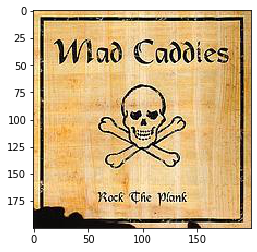

['Reggae']


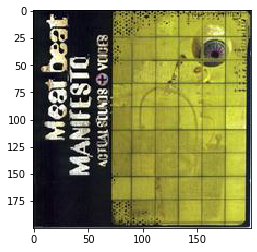

['Electronic']


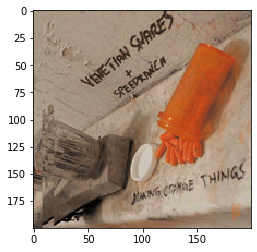

['Electronic']
time: 4min 1s


In [0]:
X_test = loader.load_img(20000, 21000, df)
y_test = loader.load_label(20000, 21000, df)
# Indexes 20000 - 21000 are way out of the training set

test_result = model.evaluate(X_test, y_test)
print(test_result)

for i in range(3):
  plt.imshow(X_test[i])
  plt.show()
  img = X_test[i].reshape((1, 200, 200, 3)).astype(np.float64)
  print(msdi_io.dummies_to_labels(model.predict(img)))